In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from rbm import BRBM as RBM
from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
kdd_data = fetch_kddcup99(percent10 = False) # takes a few minutes
X, y = kdd_data.data, kdd_data.target

In [4]:
kdd_data = fetch_kddcup99(percent10 = True) # faster approach (but number of features later = 118 not 122 :/)
X, y = kdd_data.data, kdd_data.target

In [5]:
# TODO do it exactly same way as they done it in paper
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

In [6]:
X_test.shape

(148207, 41)

In [7]:
X.shape

(345814, 41)

In [9]:
X[:5, :]

array([[0, b'icmp', b'ecr_i', b'SF', 1032, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 511, 511, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        255, 255, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0, b'icmp', b'ecr_i', b'SF', 1032, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 511, 511, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        255, 255, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0, b'icmp', b'ecr_i', b'SF', 520, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 457, 457, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        255, 255, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0, b'icmp', b'ecr_i', b'SF', 1032, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 511, 511, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        255, 255, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0, b'icmp', b'ecr_i', b'SF', 1032, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 511, 511, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,
        255, 255, 1.0, 0.0, 1.

In [10]:
y

array([b'smurf.', b'smurf.', b'smurf.', ..., b'normal.', b'neptune.',
       b'neptune.'], dtype=object)

In [11]:
y = np.array([label.decode('utf8') for label in y])
y_test = np.array([label.decode('utf8') for label in y_test])
print(y[:5])

['smurf.' 'smurf.' 'smurf.' 'smurf.' 'smurf.']


In [12]:
for label, count in Counter(y).items():
    print(f"{label}: {count}")

smurf.: 196553
back.: 1542
neptune.: 75041
normal.: 68094
portsweep.: 728
teardrop.: 685
guess_passwd.: 37
satan.: 1112
ipsweep.: 873
warezclient.: 714
pod.: 185
land.: 15
nmap.: 162
phf.: 3
buffer_overflow.: 21
ftp_write.: 6
warezmaster.: 14
multihop.: 5
perl.: 2
loadmodule.: 6
rootkit.: 7
imap.: 8
spy.: 1


In [13]:
# TODO check this - also maybe this stuff is/should be in rbm class (?)
def softmax(z):
    z_exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    return z_exp / np.sum(z_exp, axis=1, keepdims=True)

def one_hot_encode_labels(y, class_list):
    n = len(y)
    K = len(class_list)
    one_hot = np.zeros((n, K))
    label_to_idx = {label: idx for idx, label in enumerate(class_list)}
    for i, label in enumerate(y):
        one_hot[i, label_to_idx[label]] = 1
    return one_hot, label_to_idx

def softmax_train(X, Y, lr=0.01, iterations=500, verbose=False):
    # Y as one-hot labels
    n_samples, n_features = X.shape
    K = Y.shape[1]
    W = np.random.randn(n_features, K) * 0.01
    b = np.zeros((1, K))
    
    for i in range(iterations):
        logits = np.dot(X, W) + b
        probs = softmax(logits)
        if verbose and i % 100 == 0:
            loss = -np.sum(Y * np.log(probs + 1e-8)) / n_samples
            print(f"Iteration {i}: Loss = {loss:.4f}")
            
        grad_logits = (probs - Y) / n_samples
        grad_W = np.dot(X.T, grad_logits)
        grad_b = np.sum(grad_logits, axis=0, keepdims=True)
        
        W -= lr * grad_W
        b -= lr * grad_b
    return W, b

def softmax_predict(X, W, b):
    logits = np.dot(X, W) + b
    probs = softmax(logits)
    return np.argmax(probs, axis=1)


# source: https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate"
]

df_train = pd.DataFrame(X, columns=columns)
df_test = pd.DataFrame(X_test, columns=columns)

# categorical features to one hot encoding, like paper does
categorical_cols = ["protocol_type", "service", "flag"]
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df_train[categorical_cols])
cat_train = encoder.transform(df_train[categorical_cols])
cat_test = encoder.transform(df_test[categorical_cols])

# 38 numeric features
numeric_cols = [col for col in columns if col not in categorical_cols]
num_train = df_train[numeric_cols].astype(float).values
num_test = df_test[numeric_cols].astype(float).values

# standarization
scaler = StandardScaler()
num_train_std = scaler.fit_transform(num_train)
num_test_std = scaler.transform(num_test)

# normalization
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
num_train_norm = minmax_scaler.fit_transform(num_train_std)
num_test_norm = minmax_scaler.transform(num_test_std)

X_train_processed = np.hstack([cat_train, num_train_norm])
X_test_processed = np.hstack([cat_test, num_test_norm])

# 122 columns, just like in paper
print("Processed training data shape:", X_train_processed.shape)
print("Processed testing data shape:", X_test_processed.shape)

Processed training data shape: (345814, 118)
Processed testing data shape: (148207, 118)


In [15]:
# attack types to 4 basic groups - based on "A comparison of the NSL-KDD dataset and its predecessor the KDD Cup ’99 dataset", Yassine SAHLI
dos_attacks = {"back.", "land.", "neptune.", "pod.", "smurf.", "teardrop."}
probing_attacks = {"ipsweep.", "nmap.", "portsweep.", "satan."}
u2r_attacks = {"buffer_overflow.", "loadmodule.", "perl.", "rootkit."}
r2l_attacks = {"ftp_write.", "guess_passwd.", "imap.", "multihop.", "phf.", "spy.", "warezclient.", "warezmaster."}

def map_label(label):
    if label == "normal.":
        return "normal"
    elif label in dos_attacks:
        return "DoS"
    elif label in r2l_attacks:
        return "R2L"
    elif label in u2r_attacks:
        return "U2R"
    elif label in probing_attacks:
        return "Probing"
    else:
        return label
    
y_train_mapped = np.array([map_label(lbl) for lbl in y])
y_test_mapped = np.array([map_label(lbl) for lbl in y_test])

class_list = ["normal", "DoS", "R2L", "U2R", "Probing"]

# normal vs attack label
def binary_label(label):
    return "normal" if label == "normal" else "attack"

y_train_binary = np.array([binary_label(lbl) for lbl in y_train_mapped])
y_test_binary = np.array([binary_label(lbl) for lbl in y_test_mapped])

# one hot labels for softmax (multiclass)
Y_train_onehot, label_to_idx = one_hot_encode_labels(y_train_mapped, class_list)
Y_test_onehot, _ = one_hot_encode_labels(y_test_mapped, class_list)

In [23]:
Y_train_onehot[:10] # all classes considered

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [16]:
n_visible = X_train_processed.shape[1]  # 122
n_hidden = 50
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm.fit(X_train_processed, iterations=20, learning_rate=0.01, cd_n=1)
print("RBM training complete.")
print(datetime.datetime.now())

H_train = np.array([rbm.draw_hidden(x) for x in X_train_processed])
H_test = np.array([rbm.draw_hidden(x) for x in X_test_processed])

print(datetime.datetime.now())

# softmax multiclass classification
print("Training softmax classifier on RBM features...")
W_softmax, b_softmax = softmax_train(H_train, Y_train_onehot, lr=0.1, iterations=500, verbose=True)

test_preds_idx = softmax_predict(H_test, W_softmax, b_softmax)
test_preds_labels = [class_list[idx] for idx in test_preds_idx]

# not normal -> attack
test_preds_binary = np.array(["normal" if lbl == "normal" else "attack" for lbl in test_preds_labels])

print(datetime.datetime.now())


2025-05-08 16:35:59.071146
Training RBM using the original RBM code...
RBM training complete.
2025-05-08 16:54:01.302492
2025-05-08 16:54:16.172231
Training softmax classifier on RBM features...
Iteration 0: Loss = 1.6364
Iteration 100: Loss = 0.1271
Iteration 200: Loss = 0.1018
Iteration 300: Loss = 0.0920
Iteration 400: Loss = 0.0865
2025-05-08 16:54:45.557921


In [17]:
TP = np.sum((y_test_binary == "attack") & (test_preds_binary == "attack"))
FN = np.sum((y_test_binary == "attack") & (test_preds_binary == "normal"))
TN = np.sum((y_test_binary == "normal") & (test_preds_binary == "normal"))
FP = np.sum((y_test_binary == "normal") & (test_preds_binary == "attack"))

total = len(y_test_binary)
accuracy = ((TP + TN) / total) * 100

TP_rate = (TP / (TP + FN)) * 100
FN_rate = (FN / (TP + FN)) * 100
TN_rate = (TN / (TN + FP)) * 100
FP_rate = (FP / (TN + FP)) * 100

print("------ Evaluation binary ------")
print(f"Accuracy: {accuracy:.2f}%")
print(f"TP (Detection rate): {TP_rate:.2f}%")
print(f"TN: {TN_rate:.2f}%")
print(f"FP: {FP_rate:.2f}%")
print(f"FN: {FN_rate:.2f}%")


------ Evaluation binary ------
Accuracy: 98.56%
TP (Detection rate): 98.48%
TN: 98.90%
FP: 1.10%
FN: 1.52%


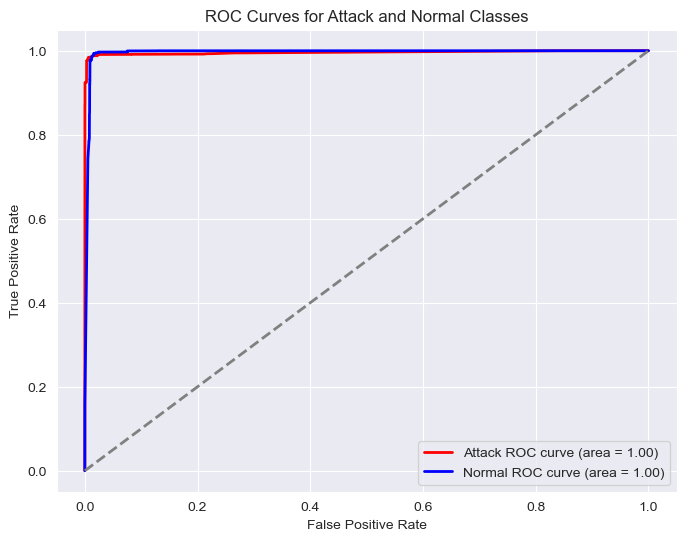

In [18]:
logits = np.dot(H_test, W_softmax) + b_softmax
probs = softmax(logits)

normal_scores = probs[:, 0]  # probability of normal
attack_scores = 1 - normal_scores

y_true_attack = np.array([1 if label != "normal" else 0 for label in y_test_binary])
y_true_normal = np.array([1 if label == "normal" else 0 for label in y_test_binary])

fpr_attack, tpr_attack, _ = roc_curve(y_true_attack, attack_scores)
roc_auc_attack = auc(fpr_attack, tpr_attack)

fpr_normal, tpr_normal, _ = roc_curve(y_true_normal, normal_scores)
roc_auc_normal = auc(fpr_normal, tpr_normal)

plt.figure(figsize=(8, 6))
plt.plot(fpr_attack, tpr_attack, color='red', lw=2,
         label='Attack ROC curve (area = %0.2f)' % roc_auc_attack)
plt.plot(fpr_normal, tpr_normal, color='blue', lw=2,
         label='Normal ROC curve (area = %0.2f)' % roc_auc_normal)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Attack and Normal Classes')
plt.legend(loc="lower right")
plt.show()

In [19]:
print("------ Evaluation multiclass ------")

y_test_mapped = np.array([map_label(label) for label in y_test])

class_order = class_list
results = []
for cls in class_order:
    total = np.sum(y_test_mapped == cls)
    correct = np.sum((y_test_mapped == cls) & (np.array(test_preds_labels) == cls))
    accuracy = (correct / total * 100) if total > 0 else 0
    results.append({
        "Attack Class": cls,
        "Number of Attacks": total,
        "Accurately Classified": correct,
        "Accuracy": f"{accuracy:.2f}%"
    })

df_results = pd.DataFrame(results)

total_attacks = df_results["Number of Attacks"].sum()
total_correct = df_results["Accurately Classified"].sum()
overall_accuracy = (total_correct / total_attacks * 100) if total_attacks > 0 else 0

total_row = {
    "Attack Class": "Total",
    "Number of Attacks": total_attacks,
    "Accurately Classified": total_correct,
    "Accuracy": f"{overall_accuracy:.2f}%"
}
df_results = pd.concat([df_results, pd.DataFrame([total_row])], ignore_index=True)
print(df_results.to_string(index=False))

------ Evaluation multiclass ------
Attack Class  Number of Attacks  Accurately Classified Accuracy
      normal              29184                  28863   98.90%
         DoS             117437                 116480   99.19%
         R2L                338                      0    0.00%
         U2R                 16                      0    0.00%
     Probing               1232                      0    0.00%
       Total             148207                 145343   98.07%


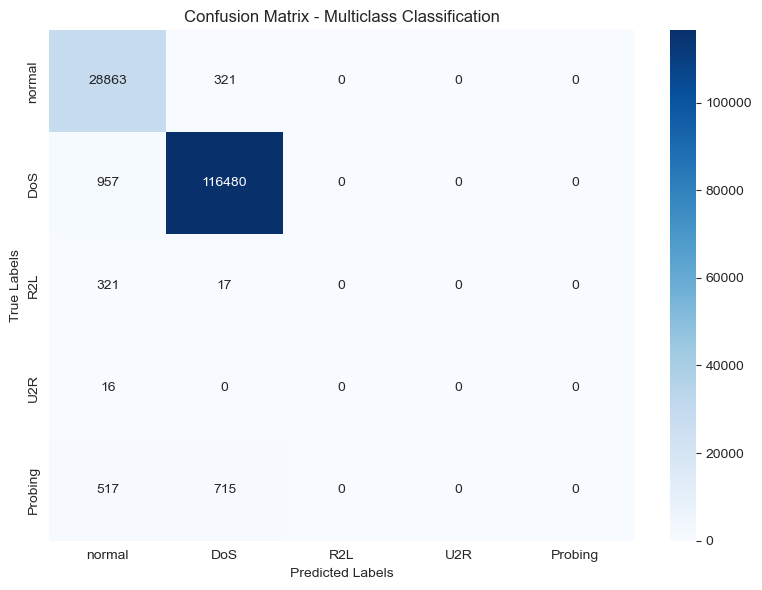

In [20]:
cm_multi = confusion_matrix(y_test_mapped, test_preds_labels, labels=class_order)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt="d", cmap="Blues", xticklabels=class_order, yticklabels=class_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Multiclass Classification")
plt.tight_layout()
plt.show()

### Old results (train dataset - full KDDCUP99, test dataset - 10% KDDCUP99)

In [71]:
n_visible = X_train_processed.shape[1]  # 122
n_hidden = 50
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden)

print(datetime.datetime.now())
print("Training RBM using the original RBM code...")
rbm.fit(X_train_processed, iterations=20, learning_rate=0.01, cd_n=1)
print("RBM training complete.")
print(datetime.datetime.now())


def rbm_transform(rbm_instance, X):
    H = []
    for x in X:
        h_prob = rbm_instance.h_probability(x)
        H.append(h_prob)
    return np.array(H)

H_train = rbm_transform(rbm, X_train_processed)
H_test = rbm_transform(rbm, X_test_processed)

print(datetime.datetime.now())

# softmax multiclass classification
print("Training softmax classifier on RBM features...")
W_softmax, b_softmax = softmax_train(H_train, Y_train_onehot, lr=0.1, iterations=500, verbose=True)

test_preds_idx = softmax_predict(H_test, W_softmax, b_softmax)
test_preds_labels = [class_list[idx] for idx in test_preds_idx]

# not normal -> attack
test_preds_binary = np.array(["normal" if lbl == "normal" else "attack" for lbl in test_preds_labels])

print(datetime.datetime.now())

TP = np.sum((y_test_binary == "attack") & (test_preds_binary == "attack"))
FN = np.sum((y_test_binary == "attack") & (test_preds_binary == "normal"))
detection_rate = (TP / (TP + FN) * 100) if (TP + FN) > 0 else 0
false_negative_rate = (FN / (TP + FN) * 100) if (TP + FN) > 0 else 0

print("------ Evaluation ------")
print(f"Detection Rate: {detection_rate:.2f}%")
print(f"False Negative Rate: {false_negative_rate:.2f}%")

cm = confusion_matrix(y_test_binary, test_preds_binary, labels=["normal", "attack"])
print("Confusion Matrix (rows: true labels, columns: predicted labels):")
print(cm)

print(datetime.datetime.now())

2025-04-09 00:34:55.384592
Training RBM using the original RBM code...
RBM training complete.
2025-04-09 10:09:57.986859
2025-04-09 10:10:52.304735
Training softmax classifier on RBM features...
Iteration 0: Loss = 1.6264
Iteration 100: Loss = 0.1396
Iteration 200: Loss = 0.0969
Iteration 300: Loss = 0.0810
Iteration 400: Loss = 0.0720
2025-04-09 10:28:57.456330
------ Evaluation ------
Detection Rate: 98.85%
False Negative Rate: 1.15%
Confusion Matrix (rows: true labels, columns: predicted labels):
[[ 95492   1786]
 [  4582 392161]]
2025-04-09 10:28:58.219867


In [81]:
TP = np.sum((y_test_binary == "attack") & (test_preds_binary == "attack"))
FN = np.sum((y_test_binary == "attack") & (test_preds_binary == "normal"))
TN = np.sum((y_test_binary == "normal") & (test_preds_binary == "normal"))
FP = np.sum((y_test_binary == "normal") & (test_preds_binary == "attack"))

total = len(y_test_binary)
accuracy = ((TP + TN) / total) * 100

TP_rate = (TP / (TP + FN)) * 100
FN_rate = (FN / (TP + FN)) * 100
TN_rate = (TN / (TN + FP)) * 100
FP_rate = (FP / (TN + FP)) * 100

print("------ Evaluation binary ------")
print(f"Accuracy: {accuracy:.2f}%")
print(f"TP (Detection rate): {TP_rate:.2f}%")
print(f"TN: {TN_rate:.2f}%")
print(f"FP: {FP_rate:.2f}%")
print(f"FN: {FN_rate:.2f}%")


------ Evaluation binary ------
Accuracy: 98.71%
TP: 98.85%
TN: 98.16%
FP: 1.84%
FN: 1.15%


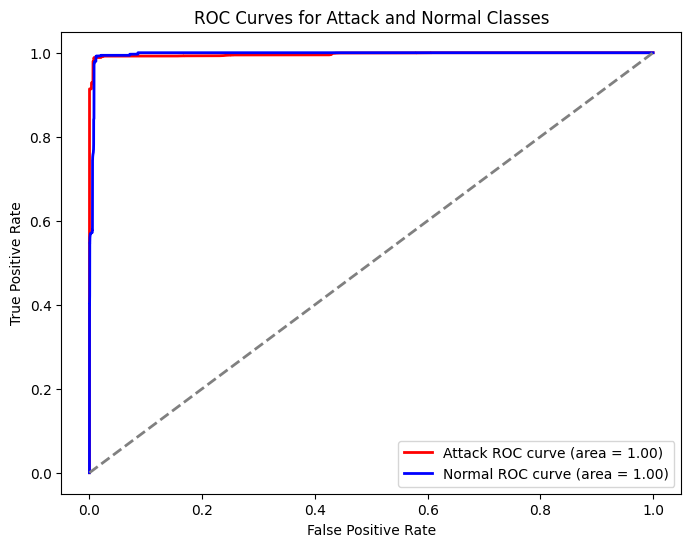

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

logits = np.dot(H_test, W_softmax) + b_softmax
probs = softmax(logits)

normal_scores = probs[:, 0]  # probab of normal
attack_scores = 1 - normal_scores


y_true_attack = np.array([1 if label != "normal" else 0 for label in y_test_binary])
y_true_normal = np.array([1 if label == "normal" else 0 for label in y_test_binary])

fpr_attack, tpr_attack, _ = roc_curve(y_true_attack, attack_scores)
roc_auc_attack = auc(fpr_attack, tpr_attack)

fpr_normal, tpr_normal, _ = roc_curve(y_true_normal, normal_scores)
roc_auc_normal = auc(fpr_normal, tpr_normal)

plt.figure(figsize=(8, 6))
plt.plot(fpr_attack, tpr_attack, color='red', lw=2,
         label='Attack ROC curve (area = %0.2f)' % roc_auc_attack)
plt.plot(fpr_normal, tpr_normal, color='blue', lw=2,
         label='Normal ROC curve (area = %0.2f)' % roc_auc_normal)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Attack and Normal Classes')
plt.legend(loc="lower right")
plt.show()
# overly optimistic

In [88]:
print("------ Evaluation multiclass ------")

y_test_mapped = np.array([map_label(label) for label in y_test])

results = []
for cls in class_order:
    total = np.sum(y_test_mapped == cls)
    correct = np.sum((y_test_mapped == cls) & (np.array(test_preds_labels) == cls))
    accuracy = (correct / total * 100) if total > 0 else 0
    results.append({
        "Attack Class": cls,
        "Number of Attacks": total,
        "Accurately Classified": correct,
        "Accuracy": f"{accuracy:.2f}%"
    })

df_results = pd.DataFrame(results)

total_attacks = df_results["Number of Attacks"].sum()
total_correct = df_results["Accurately Classified"].sum()
overall_accuracy = (total_correct / total_attacks * 100) if total_attacks > 0 else 0

total_row = {
    "Attack Class": "Total",
    "Number of Attacks": total_attacks,
    "Accurately Classified": total_correct,
    "Accuracy": f"{overall_accuracy:.2f}%"
}
df_results = pd.concat([df_results, pd.DataFrame([total_row])], ignore_index=True)
print(df_results.to_string(index=False))

------ Evaluation multiclass ------
Attack Class  Number of Attacks  Accurately Classified Accuracy
      normal              97278                  95492   98.16%
         DoS             391458                 388230   99.18%
     Probing               4107                      0    0.00%
         R2L               1126                      0    0.00%
         U2R                 52                      0    0.00%
       Total             494021                 483722   97.92%
